<a href="https://colab.research.google.com/github/lcduquev/Analisis-Numerico/blob/master/Grafo_integrador_doble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construcción del grafo del doble integrador para resolver problemas de control óptimo 

<font size="-1">**Resumen**: en el presente documento se pretende solucionar el problema de control óptimo de un doble integrador utilizando la teoría de grafos y la librería NetworkX de Python, mostrando todo el proceso de construcción del grafo para posteriormente solucionar un problema de aplicación con el grafo generado. </font>


# Contenido del documento

* [Introducción y descripción del problema](#chapter1)
* [Sobre la teoría de grafos](#chapter2)
    * [El integrador doble en forma de grafo](#section_2_1)
* [Ecuaciones matemáticas para modelar el problema](#chapter3)
* [Análisis del integrador doble](#chapter4)
* [Construcción del grafo](#chapter5)
* [Ejemplo de aplicación](#chapter6)
* [Conclusiones](#chapter7)
* [Referencias](#chapter8)
  

<a name="chapter1"></a>

## Introducción y descripción del problema 

Muchos sistemas físicos, químicos y económicos pueden ser modelados por relaciones matemáticas, tales como ecuaciones diferenciales o de diferencias ya sean determinísticas o estocásticas.

Estos sistemas pueden ser llevados de un estado a otro aplicando una fuerza externa. Si hay diferentes maneras de realizar este cambio de estados se hace necesario escoger la mejor en términos de la variable que nos interese minimizar o maximizar, como lo podría ser el consumo energético.

En la teoría de sistemas y control, el **integrador doble** es un ejemplo canónico de un sistema de control de segundo orden que modela la dinámica de una masa simple en un espacio unidimensional bajo el efecto de una entrada de fuerza variable en el tiempo $u$.

El integrador doble es un modelo matemático para un automóvil en movimiento rectilíneo sobre un plano plano y sin fricción. También constituye un modelo para sistemas eléctricos y rotacional-mecánicos análogos. Debido a su simplicidad, el control óptimo del integrador doble se estudia virtualmente en cada curso sobre la teoría del control óptimo, donde se buscan soluciones analíticas para los problemas de minimización del esfuerzo y tiempo de control. 

Como ya se mencionó, el modelo es simple, mas sin embargo encontrar la solución analítica para esa óptima fuerza externa o señal de control se puede volver más complejo entre más complicado se vuelvan los sistemas.

Una buena manera de sortear está dificultad de encontrar la solución óptima mediante el uso de herramientas del análisis numérico, que en este caso es una aproximación numerica lograda mediante la construcción de un grafo que básicamente utiliza la dinámica de solucionar el problema por camino más corto.

<a name="chapter2"></a>
## Sobre la teoría de grafos 



La teoría de grafos es el estudio de objetos matemáticos conocidos como grafos, que consisten en **vértices** (o *nodos*)   <img align="right" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/6n-graf.svg/250px-6n-graf.svg.png" width="220" height="150" alt="grafo" > conectados por **bordes**. En la figura los vértices son los círculos numerados y los bordes se unen a los vértices.

Cualquier escenario en el que se desee examinar la estructura de una red de objetos conectados es potencialmente un problema para la teoría de grafos. Los ejemplos de teoría de grafos surgen con frecuencia no solo en matemáticas sino también en física e informática.

Para esta aplicación no es relevante conocer a profundidad la teoría de grafos, pero si está interesado en el tema puede leer más [aquí](https://www.analyticsvidhya.com/blog/2018/09/introduction-graph-theory-applications-python/).


<a name="section_2_1"></a>

### Representando el integrador doble como grafo

En el grafo que vamos a generar, los nodos van a representar todos los posibles puntos del espacio de estados, mientras que los bordes van a ser los caminos que los conectan, donde cada camino va a tener un **peso** relacionado con la función que queremos optimizar, ya sea el esfuerzo o el tiempo en este caso.


 <a name="chapter3"></a>
 ## Ecuaciones matemáticas para modelar el problema

Las ecuaciones diferenciales que representan un integrador doble son:

$$\dot x_1 = x_2$$
$$\dot x_2 = u_k$$

En esta representación, está claro que la entrada de control $u$ es la segunda derivada de la salida $x_1$.

Como la señal de control se produce para modificar la variable controlada de tal forma que se disminuya o elimine el error, vamos a crear una restricción para esta, de forma tal que esté acotada en un rango y que tenga forma de delta de Dirac:

$$u_k \in Q_\delta(u),~\text{with}~ Q_\delta(u)=\delta  \lfloor \frac{u}{\delta}\rfloor,~k=\lfloor \frac{u}{\delta} \rfloor,~u\in[u_{min},u_{max}]$$

El tiempo en el que se evalúe el punto inicial debe ser menor al tiempo en el que se evalúe el punto final (optimizado).

$$(x_1(t_i),x_2(t_i))=(x_{1,i},x_{2,i})$$
$$(x_1(t_j),x_2(t_j))=(x_{1,j},x_{2,j})$$
$$t_i<t_j$$

 <a name="chapter4"></a>
## Análisis del integrador doble 

El primero paso para construir nuestro grafo es estudiar gráficamente el integrador doble bajo las restricciones descritas anteriormente. Esto nos ayudará a encontrar algunas propiedades que nos facilitarán la construcción del grafo y el entendimiento del mismo. 


##### Importamos todas las librerías necesarias para el desarrollo del proyecto

In [ ]:
]import numpy as np 
import matplotlib.pyplot as plt 

from scipy.integrate import solve_ivp
from time import time
import networkx as nx 
from math import floor

from IPython.display import clear_output

##### Definición del doble integrador como función en Python

In [ ]:
def double_integrator(t,x,u):
    return [x[1],u]

##### Definición del set de señales de control

Como se mencionó en la sección anterior, para resolver el problema mediante un grafo vamos a tener un conjunto definido de señales de control. En este caso la señal de control puede tomar cualquier magnitud entera entre -4 y 4, por lo que van a haber 9 posibles señales de control (contando el 0).

Text(0.5, 1.0, 'Conjunto de posibles señales de control')

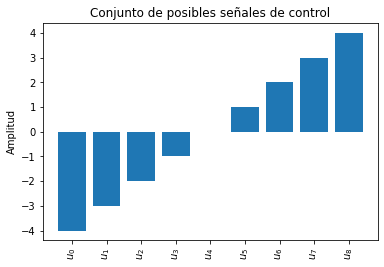

In [ ]:
du = 1
u_set = [-4,4]
u_k = np.arange(u_set[0],u_set[1]+du,du)
plt.bar(['$u_{}$'.format(i) for i in np.arange(len(u_k))],u_k,width=0.8)
plt.xticks(rotation = 90)
plt.ylabel('Amplitud')
plt.title('Conjunto de posibles señales de control')

#####  Análisis del espacio de estados 

Ahora necesitamos saber el espaciamiento en el eje x y el eje y ($dx , dy$) para construír una plantilla que mapee los posibles estados y posteriormente con ella construír el grafo. 

El esparcimiento de los ejes es:  0.005 en x y  0.1 en y


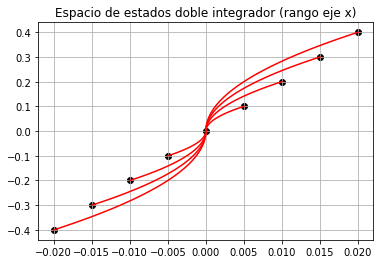

In [ ]:
dt = 0.1 # tiempo de aplicación mínimo de cada señal de control 

x0 = [0,0] # condiciones iniciales = 0 
tspan = [0,dt] # periodo de integración 

#para cada posible señal de control, resolver el doble integrador y graficar el espacio de estados
for u in u_k:
    sol = solve_ivp(double_integrator,tspan,x0,args=(u,),dense_output=True) 
    t = np.linspace(0,tspan[1],endpoint=True)
    x = sol.sol(t)
    plt.scatter(x[0,-1],x[1,-1],c='k')
    plt.plot(x[0,:],x[1,:],'r')
    plt.title('Espacio de estados doble integrador (rango eje x)')
plt.grid()

# calculamos el esparcimiento de los ejes
dx = x[0,-1]/4
dy = x[1,-1]/4

# redondeamos para evitar problemas cuando se tienen muchos decimales 
dx = abs(np.round(dx,3))
dy = abs(np.round(dy,3))

print("El esparcimiento de los ejes es: ",dx, "en x y ",dy, "en y")

La gráfica del espacio de estados anterior se realizó bajo la premisa de que no existen condiciones iniciales, por lo que el próximo paso es analizar qué pasa si estas se presentan.

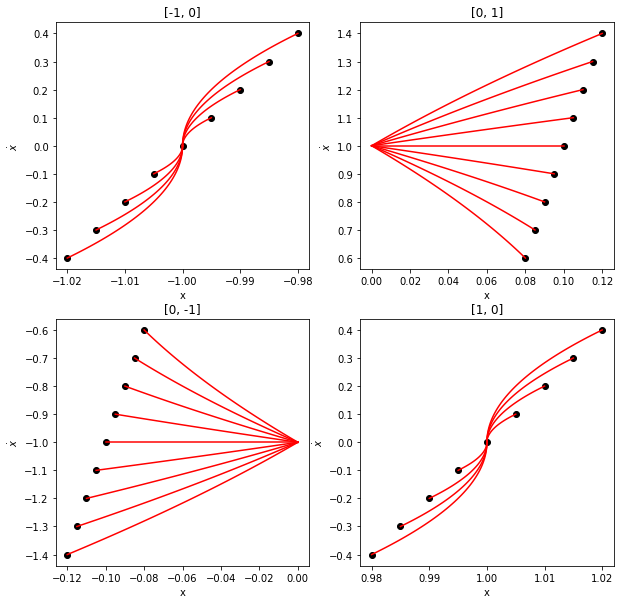

In [ ]:
# Definimos una función para resolver el doble integrador
def plot_plantilla(double_integrator,u_k,x0= [0,0],tspan=[0,dt],color='r',trayectory=True):
    for u in u_k:
        sol = solve_ivp(double_integrator,tspan,x0,args=(u,),dense_output=True) 
        t = np.linspace(0,tspan[1],endpoint=True)
        x = sol.sol(t)
        plt.scatter(sol.y[0,-1],sol.y[1,-1],c='k')
        if trayectory:
            plt.plot(x[0,:],x[1,:],color)

# Definimos algunas condiciones iniciales             
x0s = [[-1,0],[0,1],[0,-1],[1,0]]

# Organizamos las gráficas
plt.figure(figsize=(10,10))
for i,x0 in enumerate(x0s):
    plt.subplot(2,2,i+1)
    plt.title('{}'.format(x0))
    plt.xlabel('x')
    plt.ylabel('$\dot{x}$')
    plot_plantilla(double_integrator,u_k,x0)

De las gráficas anteriores podemos deducir dos cosas. Primero, se produce un cambio de forma en el espacio de estados cuando varía la condición inicial en el eje $y$; segundo, es observable que el distanciamiento entre puntos adyacentes es igual para todos los puntos.

Recordemos que estos puntos crean un límite en el espacio de estados, por lo que los estamos explorando para acotar los puntos con las que construiremos nuestro grafo (nodos).

Las observaciones anteriores nos permiten inferir que para crear la plantilla o template debemos variar la posición del estado inicial solo en el eje $y$ con un $dy$ de espaciamiento. Esto es debido a que la forma de la figura que cambia cando se mueve en el eje $y$, pero no cambia cuando se desplaza en el eje $x$.

##### Plantilla o template

Definimos el rango del eje $y$ que deseamos. Aquí se escoge un rango pequeño ($[-2,2]$) debido al coste computacional.

In [ ]:
#Definimos el rango para el eje y con un esparcimiento de dy (0.1)
y_min,y_max = -2,2
rango_y = np.arange(y_min,y_max,dy)

Text(0.5, 1.0, 'Espacio de estados cambiando la coordenada y de la condición inicial')

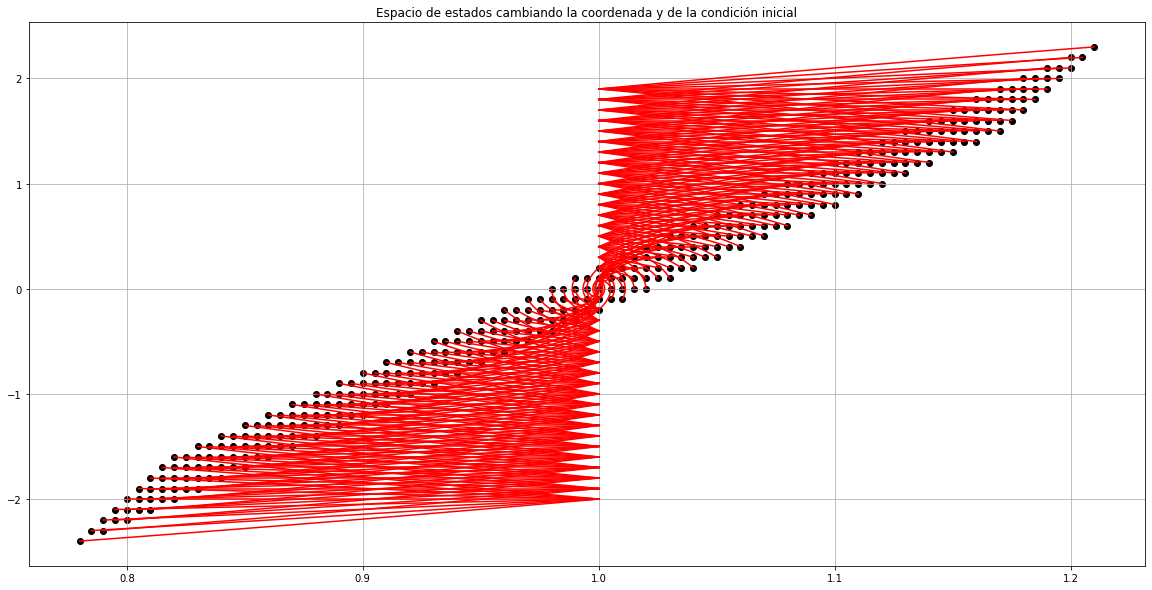

In [ ]:
# Graficamos el espacio de estados para este nuevo rango utilizando la misma función que antes, cambiando solamente la coordenada y de la condición inicial
plt.figure(figsize=(20,10))
for i in rango_y:
    plot_plantilla(double_integrator,u_k,x0=[1,i],color='r',trayectory =True)
plt.grid()
plt.title('Espacio de estados cambiando la coordenada y de la condición inicial')

#### Construcción de la función para la plantilla

La plantilla es una representación matricial de la figura anterior que va a tener los siguientes campos: 


Columna 1|columna 2|columna 3|columna 4| columna 5
:---|:---|:---|:---|:---
nodo inicial x | nodo inicial y | nodo final x | nodo final y | señal de control

Y representa la trayectoria de un nodo inicial (condición inicial) al nodo final(condición final) que se logra poniendo la señal de control especificada en la quinta columna al sistema.

In [ ]:
# Definimos la función para generar la plantilla basados en la gráfica anterior 

def Tplantilla(double_integrator,u_k,altura,tspan=[0,dt]):
    template = np.zeros((len(altura)*len(u_k),5)) #creamos un arreglo de ceros 
    contador = 0
    for j,alt in enumerate(altura):   # para cada punto del rango en y se varía la condición inicial
        x0 = [0,alt]
        for i,u in enumerate(u_k):
            sol = solve_ivp(double_integrator,tspan,x0,args=(u,),dense_output=True)   # solución del doble integrador
            t = np.linspace(0,tspan[1],endpoint=True)
            x = sol.sol(t)
            template[contador,...] = x0[0],x0[1],sol.y[0,-1],sol.y[1,-1],u  #creamos la plantilla con la estructura que se mencionó en el cuadro anterior
            contador += 1
    return template

In [ ]:
# Generamos nuestra plantilla definitiva
template = Tplantilla(double_integrator,u_k,rango_y) #(begin_node_x,begind_node_y,end_node_x,end_node_y,u_signal)

# Redondeamos los números porque estos serán las etiquetas de cada nodo en el grafo
template[0,:] = np.round(template[0,:],3)  
template[2,:] = np.round(template[2,:],3) 
template[1,:] = np.round(template[1,:],1) 
template[3,:] = np.round(template[3,:],1) 

##### Espacio de trabjo 

Ahora vamos a visualizar el espacio de trabajo. El espacio de trabajo nos muestra todos los valores posibles que van a poder representarse en el grafo dados deltas de cada eje.  


In [ ]:
# El eje x puede tener o crear los puntos que desee, mientras que el eje y está restringido por el máximo de los 
# puntos del template, eso se explica por la gráfica, podemos moverla libremente por el eje x y sin afectar su 
# forma pero eso no sucede con el eje y 

Nx = 400 #número de puntos eje x N_x*2 + 1
Ny = 20 #número de puntos eje y N_y*2 + 1 
x1s = np.round(np.arange(-dx*Nx,dx*Nx+dx,dx),3) #las cifras decimales dependen de los delta de cada eje 
x2s = np.round(np.arange(-dy*Ny,dy*Ny+dy,dy),1)
len(x1s)*len(x2s) # cantidad total de puntos posibles en el espacio de trabajo

32841

In [ ]:
X,Y = np.meshgrid(x1s,x2s)

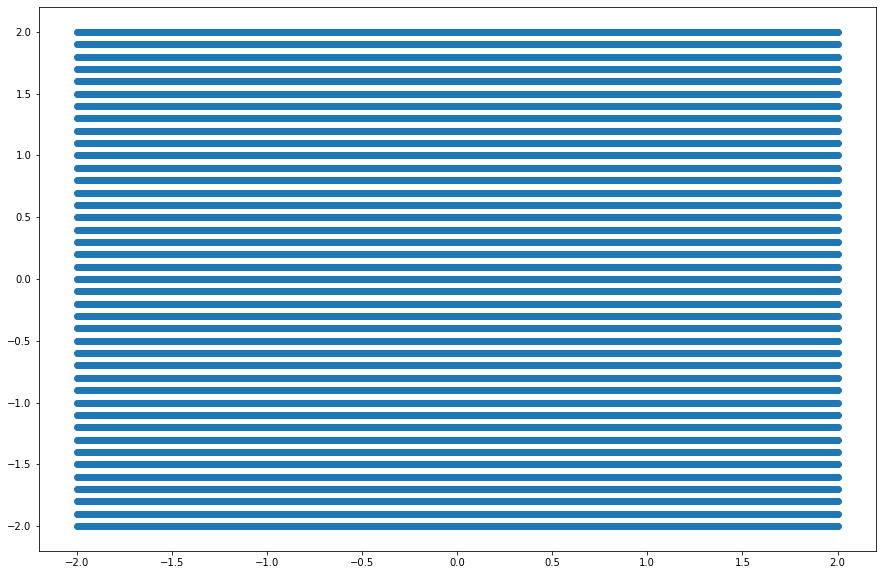

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(X,Y)

 <a name="chapter5"></a>
## Construcción del grafo 
Cada punto del espacio de trabajo se mira principalmente como un punto final para crear el grafo, las preguntas que siempre se hacen son, ¿desde qué puntos puedo llegar a un punto especifico? y ¿qué señal de control me permite esto?; con esas dos preguntas en mente se monta el grafo.

Las etiquetas que se le asignaron a cada nodo (que representa un punto en el espacio de estados) son las coordenadas del punto, esto por facilidad a la hora de consultar en el grafo, aunque acarrea realizar aproximaciónes o redondeos para evitar duplicación de nodos.

Cada punto del espacio de trabajo va a ser un nodo, pero no van a ser los únicos ya que pueden haber puntos fuera del espacio de trabajo que conduzcan a nodos que sí estén dentro del espacio. Estos punto fuera del espacio de trabajo solo van a poder ser puntos iniciales, nunca funales no finales, en cambio, si todo va bien con el grafo, los puntos del espacio de trabajo podran ser iniciales y finales.

Con esto en mente estamos listos para construir el grafo. El primer paso es iterar sobre cada punto del espacio de trabajo, preguntando en cada uno qué puntos o nodos llegan a él; pero cuidado hay muchos puntos fuera del template. Para solcuionar esto es necesario recordar lo que se habla desde el inicio, podemos correr el template en el eje $x$ sin que el espacio de estados cambie su forma, entonces esto es lo que hacemos, movemos el template en ese eje de tal manera que el punto que estamos analizando entre en él. Además, es necesario correr el template al mismo número de puntos que este paralelos al eje $x$ en la altura del punto que estamos analizando, al realizar este proceso los puntos se van conectando hasta contruir todo el grafo. 

In [ ]:
# Ahora sí, vamos a construir el grafo utilizando la librería NetrowkX 

G = nx.DiGraph() # Definimos el grafo

start = time()
contador = 1
for x1 in x1s: 
    for x2 in x2s:
        new_point =[x1,x2]      # creamos un punto nuevo
        
        super_point = template[np.round(template[:,3],1) == new_point[1]]       #tomamos todos los nodos finales en y los llamamos superpunto
        super_point[:,0] = np.round(super_point[:,0] + new_point[0] - super_point[:,2],3)
        super_point[:,2:4] = np.round(new_point[0],3),np.round(new_point[1],1)    # redondeamos los nodos finales y la señal de control
        
        # evitar errores con los decimales en las etiquetas
        super_point[super_point == 0] = np.float64(0)
        
        #conectamos todos los puntos iniciales con el punto final que estamos analizando en la presente iteración 
        # la librería se encarga de agregarle los pesos a cada uno de los bordes basandose en la señal de control
        # para optimizar el sistema de forma que realice el menor esfuerzo 
        for i in range(super_point.shape[0]):
            G.add_weighted_edges_from([(str(super_point[i,0:2]),str(super_point[i,2:4]),super_point[i,4]**2)],
                              weight='weight',signal =super_point[i,4],time =dt)
         
        #código para mirar el avance 
        clear_output(wait = True)
        print(np.round(100*contador/(len(x1s)*len(x2s)),4))
        contador = contador + 1
        
    
time()-start

100.0


170.59718227386475

Guardamos el grafo en disco 

In [ ]:
nx.write_gml(G, "grafo.gml")

In [ ]:
G = nx.read_gml("grafo.gml")

In [ ]:
len(G.nodes), len(G.edges)

(34594, 275544)

Observar que se tienen más bordes que nodos en el espacio de trabajo. Esto es debido a que un solo nodo puede estar conectado a múltiples otros, lo que resulta en una mayor cantidad de bordes.

 <a name="chapter6"></a>
## Ejemplo de aplicación 

Queremos llevar el sistema desde $ x(0) = 1,  \dot{x}(0) = 1 $ hasta el punto $x(t_f) = 1, \ \dot{x}(t_f) = 0 $ 
con minimo esfuerzo de control.

Recordar que los puntos deben estar entre $x_{min} = -2, \ x_{max} = 2, \ y_{min} = -2, \ y_{max} = 2$ y con un espaciamiento de $dx$, $dy$.

In [ ]:
# Definimos una función para encontrar los caminos más cortos con el criterio de mínimo esfuerzo de control y redondeamos los valores de los nodos 
def get_paths(begin_node,end_node):
    begin_node = np.float64(np.round(begin_node,3)) 
    end_node = np.float64(np.round(end_node,1))
    begin_node_str =str(begin_node)
    end_node_str =str(end_node)
    try:
        paths = list(nx.all_shortest_paths(G,begin_node_str,end_node_str,weight='weight'))
        return paths 
    except:
        return None 

# Definimos una función para ver cada una de las señales de control aplicadas en el espacio de estados
def secuencia_control(nodes):
    dict_ = []
    for i in range(len(nodes)-1):
        dict_.append(G.get_edge_data(nodes[i],nodes[i+1])['signal'])
    signal =np.array([x for x in dict_])
    return signal

# Definimos una función para evaluar la solución de los caminos encontrados (puntos que unen los nodos iniciales y finales) (salida)
# Construímos el espacio de estados
def solve_path(x0,singal):
    solucion = np.array([[0],[0]])
    points = []
    for i,u in enumerate(signal):
        tspan=[i*dt,(i+1)*dt]
        t = np.arange(i*dt,(i+1)*dt,0.001)
        sol = solve_ivp(double_integrator,tspan,x0,args=(u,),dense_output=True)
        solucion = np.concatenate((solucion, sol.sol(t)),axis=1)
        x0 = sol.y[:,-1]
        points.append(x0)
        
    return solucion[:,1:], points

In [ ]:
begin_node = [1, 1] #nodo de inicio
end_node =[0,0] # nodo final 

In [ ]:
paths = get_paths(begin_node,end_node)
nodes = paths[0]

signal = secuencia_control(nodes)
y,points = solve_path(begin_node,signal)

total_paths = len(paths)
esfuerzo = np.sum(signal**2)*dt

Text(0.5, 1.0, 'Señales de control, esfuerzo de control 1.4000000000000001')

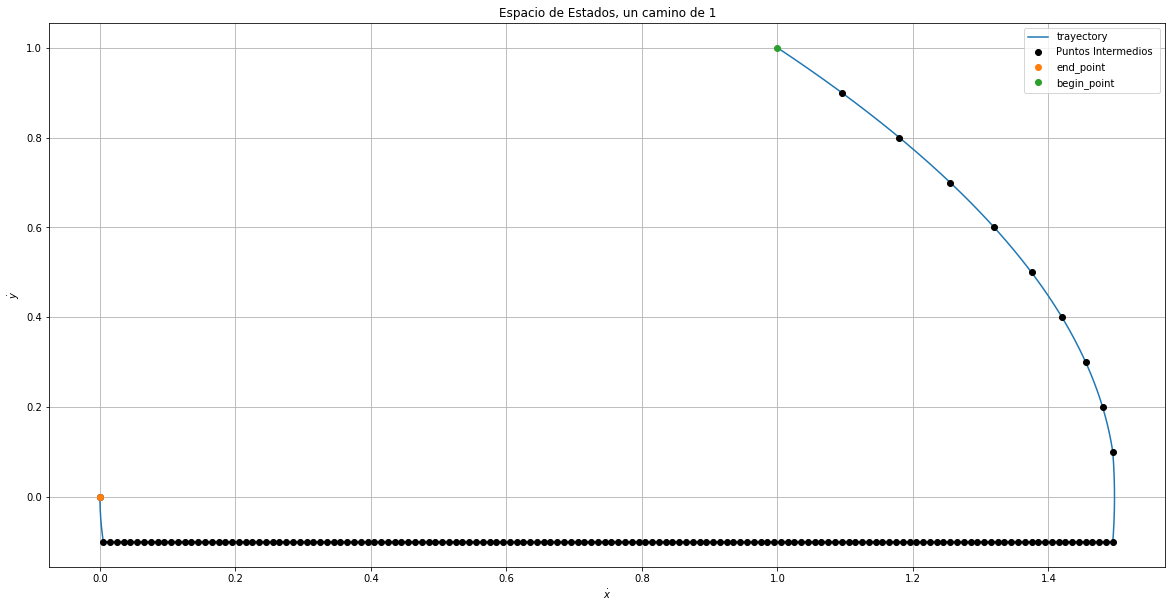

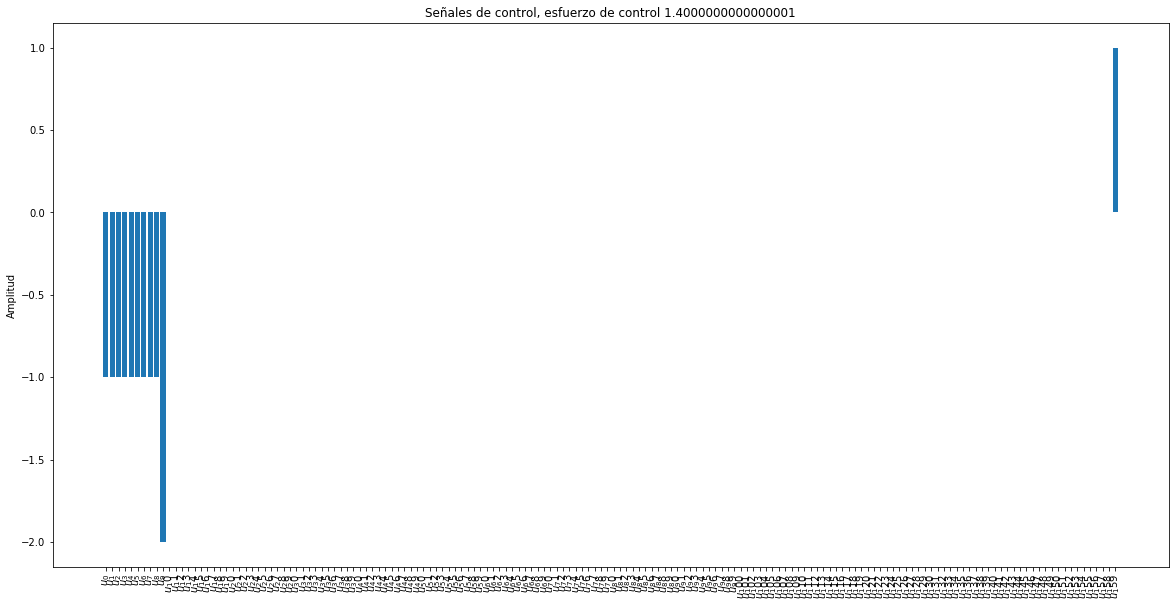

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(y[0,:],y[1,:])

#puntos intermedios 
plt.plot( np.asarray(points)[:,0], np.asarray(points)[:,1],'ok')

#puntos extremos 
plt.plot(end_node[0],end_node[1],'o')
plt.plot(begin_node[0],begin_node[1],'o')

plt.grid()
plt.xlabel('$\dot{x}$')
plt.ylabel('$\dot{y}$')
plt.title('Espacio de Estados, un camino de {}'.format(total_paths))
plt.legend(['trayectory','Puntos Intermedios ','end_point', 'begin_point'])

plt.figure(figsize=(20,10))
plt.bar(['$u_{}$'.format(i) for i in np.arange(len(signal))],signal,width=0.8)
plt.xticks(rotation = 90)
plt.ylabel('Amplitud')
plt.title('Señales de control, esfuerzo de control {}'.format(esfuerzo))

 <a name="chapter7"></a>
## Concluciones

* El análisis numérico transforma las dificulatades de encontrar la solución analíticamente a necesidades computacionales que pueden ser altas entre más complicado sea el modelo.
* Una aproximación matemática al problema puede ser de gran ayuda para entender el modelo.
* La construcción del grafo requiere un tiempo de computo considerable entre mas pequeña sea la resolución del espacio.

 <a name="chapter8"></a>
## Referencias
* [The course page of MEC 560, Optimal control](https://mec560sbu.github.io/2016/09/25/Opt_control/)
* [Optimal control of double integrator with minimum total variation, C. Yalçın Kaya](https://www.researchgate.net/publication/330132751_Optimal_control_of_double_integrator_with_minimum_total_variation)
* [Introduction into Graph Theory Using Python](https://www.python-course.eu/graphs_python.php)
* [Double integrator](https://en.wikipedia.org/wiki/Double_integrator)
* Optimal Control Systems (Electrical Engineering Series) 1st Edición de D. Subbaram Naidu